In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import math
import random
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def feature_scaling(df):

    columns = df.columns

    df[columns[:-1]] = (df[columns[:-1]] - df[columns[:-1]].mean(axis=0))/ df[columns[:-1]].std(axis=0)
    
    return df

In [ ]:
def prepare_data(size=0.8, scaling=True):
    
    def f(x):
        if x == 'Male':
            return 1
        return 0

    df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/male_or_female.csv")
    
    df['gender'] = df['gender'].apply(f)

    if scaling:
      df = feature_scaling(df)

    df_true = df[df['gender'] == 1]
    df_false = df[df['gender'] == 0]
    
    n_true = df_true.shape[0]
    n_false = df_false.shape[0]
    
    columns = df.columns

    cache = dict()
    
    x_true = df_true[columns[:-1]]
    x_false = df_false[columns[:-1]]
    y_true = df_true[columns[-1]]
    y_false = df_false[columns[-1]]
    
    m_true = int(n_true * size)
    m_false = int(n_false * size)

    
    x_train, y_train, x_test, y_test = pd.concat([x_true[:m_true], x_false[:m_false]]), pd.concat([y_true[:m_true], y_false[:m_false]]), pd.concat([x_true[m_true:], x_false[m_false:]]), pd.concat([y_true[m_true:], y_false[m_false:]])
    x_train['x'] = x_test['x'] = 1

    permutation_train = np.random.permutation(x_train.shape[0])
    permutation_test = np.random.permutation(x_test.shape[0])

    cache['x_train'] = x_train.iloc[permutation_train]
    cache['y_train'] = y_train.iloc[permutation_train]
    cache['x_test'] = x_test.iloc[permutation_test]
    cache['y_test'] = y_test.iloc[permutation_test]
    
    return cache

In [ ]:
def random_mini_batches(X, Y, mini_batch_size = 1024):
    
    m = X.shape[0]                 
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X.iloc[permutation]
    shuffled_Y = Y.iloc[permutation]
    
    inc = mini_batch_size

    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(num_complete_minibatches):
        
        mini_batch_X = shuffled_X[k * inc:(k + 1) * inc]
        mini_batch_Y = shuffled_Y[k * inc:(k + 1) * inc]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[(k + 1) * inc:]
        mini_batch_Y = shuffled_Y[(k + 1) * inc:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
        num_complete_minibatches += 1
    
    return num_complete_minibatches, mini_batches

In [ ]:
def initialize_parameters(layers_dims):
    
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):

        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [ ]:
def initialize_velocity(parameters):

    L = len(parameters) // 2 
    v = {}
    
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
        
    return v

In [ ]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(1, L + 1):

        v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
    
    return v, s

In [ ]:
def gradient_descent(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(1, L + 1):

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads['db' + str(l)]

    return parameters

In [ ]:
def gradient_descent_with_momentum(parameters, grads, v, beta, learning_rate):

    L = len(parameters) // 2

    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta * v["dW" + str(l)] + (1 - beta) * grads['dW' + str(l)]
        v["db" + str(l)] = beta * v["db" + str(l)] + (1 - beta) * grads['db' + str(l)]

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v["db" + str(l)]
        
    return parameters, v

In [ ]:
def adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                
    v_corrected = {}                         
    s_corrected = {}                         

    for l in range(1, L + 1):

        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - np.power(beta1, t))

        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads['dW' + str(l)], 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads['db' + str(l)], 2)

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - np.power(beta2, t))

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * (v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon))

    return parameters, v, s, v_corrected, s_corrected

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [ ]:
def relu(z):
    return np.where(z > 0, z, 0.01*z)

In [ ]:
def forward_propagation(X, Y, parameters, lambd):
    
    Z = {}
    A = {}
    W = {}
    b = {}
    
    L = len(parameters) // 2
    m = X.shape[0]
    
    for l in range(1, L + 1):
        
        W['W' + str(l)] = parameters['W' + str(l)]
        b['b' + str(l)] = parameters['b' + str(l)]

    Z['Z1'] = np.dot(W['W1'], X.T) + b['b1']
    A['A1'] = relu(Z['Z1'])
    
    for l in range(2, L):
        
        Z['Z' + str(l)] = np.dot(W['W' + str(l)], A['A' + str(l - 1)]) + b['b' + str(l)]
        A['A' + str(l)] = relu(Z['Z' + str(l)])
    
    Z['Z' + str(L)] = np.dot(W['W' + str(L)], A['A' + str(L - 1)]) + b['b' + str(L)]  
    A['A' + str(L)] = sigmoid(Z['Z' + str(L)])

    log_probs = np.multiply(-np.log(A['A' + str(L)]), Y.values) + np.multiply(-np.log(1 - A['A' + str(L)]), 1 - Y.values)
    
    regulizer = 0
    
    for l in range(1, L + 1):
        
        regulizer += np.sum(np.square(W['W' + str(l)]))
    
    cost = 1. / m * np.sum(log_probs) + regulizer * lambd / (2 * m)
    
    cache = (A, W)
    
    return cost, cache

In [ ]:
def backward_propagation(X, Y, cache, lambd):
    
    dZ = {}
    dA = {}
    dW = {}
    db = {}
    
    A, W = cache
    
    L = len(A)
    m = X.shape[0]
    
    dZ['dZ' + str(L)] = A['A' + str(L)] - Y.values
    dW['dW' + str(L)] = 1. / m * np.dot(dZ['dZ' + str(L)], A['A' + str(L - 1)].T) + lambd/m * W['W' + str(L)]
    dW['db' + str(L)] = 1. / m * np.sum(dZ['dZ' + str(L)], axis=1, keepdims=True)
    
    for l in range(L - 1, 1, -1):
        
        dA['dA' + str(l)] = np.dot(W['W' + str(l + 1)].T, dZ['dZ' + str(l + 1)])
        dZ['dZ' + str(l)] = np.multiply(dA['dA' + str(l)], np.int64(A['A' + str(l)] > 0))
        dW['dW' + str(l)] = 1. / m * np.dot(dZ['dZ' + str(l)], A['A' + str(l - 1)].T) + lambd/m * W['W' + str(l)]
        db['db' + str(l)] = 1. / m * np.sum(dZ['dZ' + str(l)], axis=1, keepdims=True)
        
    dA['dA1'] = np.dot(W['W2'].T, dZ['dZ2'])
    dZ['dZ1'] = np.multiply(dA['dA1'], np.int64(A['A1'] > 0))
    dW['dW1'] = 1. / m * np.dot(dZ['dZ1'], X) + lambd/m * W['W1']
    db['db1'] = 1. / m * np.sum(dZ['dZ1'], axis=1, keepdims=True)
        
    gradients = db
    gradients.update(dW)
    
    return gradients

In [ ]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, lambd = 0.001, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
            
    costs = []  
    accuracys = []
    t = 0                                                                     
    
    parameters = initialize_parameters(layers_dims)

    if optimizer == "gd":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        
        start = timeit.default_timer()
        
        m, minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0
        
        for minibatch in minibatches:

            (minibatch_X, minibatch_Y) = minibatch

            cost, caches = forward_propagation(minibatch_X, minibatch_Y, parameters, lambd)

            cost_total += cost

            grads = backward_propagation(minibatch_X, minibatch_Y, caches, lambd)

            if optimizer == "gd":
                parameters = gradient_descent(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = gradient_descent_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 
                parameters, v, s, _, _ = adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        end = timeit.default_timer()
        print(f"Epoch {i+1}/{num_epochs}: {end-start:.4f}", end=" ")
        
        if print_cost and i % 10 == 0:
            print(f"Cost after epoch {i+1}: {cost_avg:.6f}")
        else:
            print()
        if print_cost and i % 5 == 0:
            costs.append(cost_avg)
            accuracys.append(float(accuracy(parameters, X, Y).split(' ')[1]))

    plt.plot(costs, label='loss', color='red')
    plt.plot(accuracys, label='accuracy', color='blue')
    plt.xlabel('epochs (per 5)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.legend()
    plt.show()

    return parameters

In [ ]:
def accuracy(parameters, x, y):
    
    Z = {}
    A = {}
    W = {}
    b = {}
    
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        
        W['W' + str(l)] = parameters['W' + str(l)]
        b['b' + str(l)] = parameters['b' + str(l)]
    
    Z['Z1'] = np.dot(W['W1'], x.T) + b['b1']
    A['A1'] = relu(Z['Z1'])
    
    for l in range(2, L):
        
        Z['Z' + str(l)] = np.dot(W['W' + str(l)], A['A' + str(l - 1)]) + b['b' + str(l)]
        A['A' + str(l)] = relu(Z['Z' + str(l)])
    
    Z['Z' + str(L)] = np.dot(W['W' + str(L)], A['A' + str(L - 1)]) + b['b' + str(L)]  
    A['A' + str(L)] = sigmoid(Z['Z' + str(L)])
    
    m = x.shape[0]
    accuracy = 0
  
    hx = A['A' + str(L)] >= 0.5
    tp = tn = fp = fn = 0

    for i in range(m):
        if hx[0][i] == 1 and y.iloc[i] == 1:
            tp += 1
        elif hx[0][i] == 1 and y.iloc[i] == 0:
            tn += 1
        elif hx[0][i] == 0 and y.iloc[i] == 0:
            fp += 1
        else:
            fn += 1
    
    return f"accuracy: {(tp+fp)/(tp+tn+fp+fn):.6f} - true_pos: {tp} - true_neg: {tn} - false_pos: {fp} - false_neg: {fn}"

In [ ]:
def predict(parameters, x, y):
    Z = {}
    A = {}
    W = {}
    b = {}
    
    L = len(parameters) // 2
    
    for l in range(1, L + 1):
        
        W['W' + str(l)] = parameters['W' + str(l)]
        b['b' + str(l)] = parameters['b' + str(l)]
    
    Z['Z1'] = np.dot(W['W1'], x.T) + b['b1']
    A['A1'] = relu(Z['Z1'])
    
    for l in range(2, L):
        
        Z['Z' + str(l)] = np.dot(W['W' + str(l)], A['A' + str(l - 1)]) + b['b' + str(l)]
        A['A' + str(l)] = relu(Z['Z' + str(l)])
    
    Z['Z' + str(L)] = np.dot(W['W' + str(L)], A['A' + str(L - 1)]) + b['b' + str(L)]  
    A['A' + str(L)] = sigmoid(Z['Z' + str(L)])
    
    return 'Man' if A['A' + str(L)] >= 0.5 else 'Women',  'True label: Man' if y == 1 else 'True label: Women'

In [ ]:
def plot_data(x, y, dim=2):

  if dim==2:

    pca = PCA(n_components = 2)
    pca.fit(x)
    data_pca = pca.transform(x)
    data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2'])

    y = y.reset_index(drop=True)

    l_true = y[y == 1].index
    l_false = y[y == 0].index

    plt.figure(figsize=(10, 10))

    plt.scatter(data_pca.iloc[l_true]['PC1'], data_pca.iloc[l_true]['PC2'], c='green')
    plt.scatter(data_pca.iloc[l_false]['PC1'], data_pca.iloc[l_false]['PC2'], c='red')

    plt.show()

  if dim==3:

    pca = PCA(n_components = 3)
    pca.fit(x)
    data_pca = pca.transform(x)
    data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2', 'PC3'])

    y = y.reset_index(drop=True)

    l_true = y[y == 1].index
    l_false = y[y == 0].index

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.scatter(data_pca.iloc[l_true]['PC1'], data_pca.iloc[l_true]['PC2'], data_pca.iloc[l_true]['PC3'], color='green')
    ax.scatter(data_pca.iloc[l_false]['PC1'], data_pca.iloc[l_false]['PC2'], data_pca.iloc[l_false]['PC3'], color='red')

    ax.view_init(15, 90)
    plt.show()

In [151]:
cache = prepare_data(size=0.8)
layers_dims = [cache['x_train'].shape[1], 10, 8, 5, 2, 1]

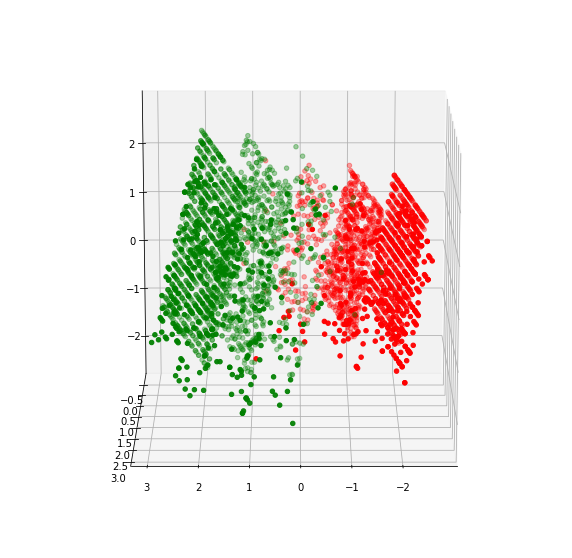

In [152]:
plot_data(cache['x_train'], cache['y_train'], dim=3)

Epoch 1/15: 0.1558 Cost after epoch 1: 0.716700
Epoch 2/15: 0.1670 
Epoch 3/15: 0.1576 
Epoch 4/15: 0.1828 
Epoch 5/15: 0.1570 
Epoch 6/15: 0.1598 
Epoch 7/15: 0.1723 
Epoch 8/15: 0.1535 
Epoch 9/15: 0.1663 
Epoch 10/15: 0.1541 
Epoch 11/15: 0.1534 Cost after epoch 11: 0.235521
Epoch 12/15: 0.2450 
Epoch 13/15: 0.4197 
Epoch 14/15: 0.3501 
Epoch 15/15: 0.3764 


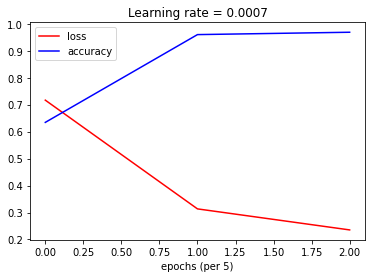

In [153]:
parameters_adam = model(cache['x_train'], cache['y_train'], layers_dims, optimizer = "adam", num_epochs = 15, mini_batch_size = 32, learning_rate = 0.0007, lambd=0.003)

In [154]:
accuracy(parameters_adam, cache['x_test'], cache['y_test'])

'accuracy: 0.975025 - true_pos: 485 - true_neg: 10 - false_pos: 491 - false_neg: 15'

In [155]:
for i in range(cache['x_test'].shape[0]):
  print(predict(parameters_adam, cache['x_test'].iloc[i].values.reshape(1, -1), cache['y_test'].iloc[i]))

('Man', 'True label: Man')
('Women', 'True label: Women')
('Man', 'True label: Women')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Women', 'True label: Women')
('Women', 'True label: Women')
('Women', 'True label: Women')
('Women', 'True label: Women')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Women', 'True label: Women')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Man', 'True label: Man')
('Women', 'True label: W